In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from optbinning import OptimalBinning
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up file paths 
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

In [95]:
# Loading data

FILE_PATH_DATA = project_root / 'data' / 'raw' / 'accepted_2007_to_2018Q4.csv.gz'
FILE_PATH_DICTIONARY = project_root / 'data' / 'raw'/ 'dictionary_approved_raw.csv' 

df = pd.read_csv(FILE_PATH_DATA, compression = 'gzip', low_memory = False)
df_dictionary = pd.read_csv(FILE_PATH_DICTIONARY, usecols = [0,1], low_memory = False)


In [96]:
# Comparing Data to Dictionary

data_columns = set(df.columns)
dictionary_columns = set(df_dictionary.iloc[:, 0].astype(str).str.strip())

common = data_columns.intersection(dictionary_columns)
in_data_only = data_columns - dictionary_columns
in_dict_only = dictionary_columns - data_columns

print(f"Total columns in Dataset: {len(data_columns)}")
print(f"Total variables in Dictionary: {len(dictionary_columns)}")
print(f"Matches found: {len(common)}\n")

print("-" * 30)
print(f"Columns in DATA but not in Dictionary ({len(in_data_only)}):")
print(list(in_data_only))

print("-" * 30)
print(f"Columns in DICTIONARY but not in Data ({len(in_dict_only)}):")
print(list(in_dict_only))

Total columns in Dataset: 151
Total variables in Dictionary: 152
Matches found: 150

------------------------------
Columns in DATA but not in Dictionary (1):
['verification_status_joint']
------------------------------
Columns in DICTIONARY but not in Data (2):
['nan', 'verified_status_joint']


In [97]:
# Make sure the names of the features match

df_dictionary.iloc[:, 0] = df_dictionary.iloc[:, 0].replace('verified_status_joint', 'verification_status_joint')
df_dictionary = df_dictionary.dropna()

In [98]:
# Save cleaned dictionary
FILE_PATH_DICTIONARY_CLEANED = project_root / 'data' / 'cleaned'/ 'dictionary_approved_cleaned.csv'

df_dictionary.to_csv(FILE_PATH_DICTIONARY_CLEANED)

In [99]:
FILE_PATH = project_root / 'data' / 'accepted_2007_to_2018Q4.csv.gz'

cols_to_keep = [
    # Target
    'loan_status',

    # Structural / Lender Features (Known at Origination)
    'term', 'loan_amnt', 'initial_list_status', 'application_type', 'installment',

    # Applicant Features (The core data)
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'delinq_2yrs', 
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'mths_since_last_delinq',
    'fico_range_low', 'fico_range_high',

    # Dates
    'issue_d', 'earliest_cr_line'
]
df = df[cols_to_keep]

In [49]:
# Checking data types for cleaning

print(df.dtypes)

object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    num_unique = df[col].nunique()
    
    print(f"Column: {col}")
    print(f"Count of unique values: {num_unique}")
    
    if num_unique < 50:
        print(f"Values: {df[col].unique()}")
    else:
        print(f"Top 10 values: {df[col].value_counts().head(10).index.tolist()}")
    
    print("-" * 30)

loan_status                object
term                       object
loan_amnt                 float64
initial_list_status        object
application_type           object
installment               float64
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
mort_acc                  float64
pub_rec_bankruptcies      float64
mths_since_last_delinq    float64
fico_range_low            float64
fico_range_high           float64
issue_d                    object
earliest_cr_line           object
dtype: object
Column: loan_status
Count of unique values: 9
Values: ['Fully Paid' 'Current' 'Charged Off' 'In Grace 

In [100]:
# Turning all variables into int usable types

target_statuses = [
    'Fully Paid', 
    'Charged Off', 
    'Default', 
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off'
]

df = df[df['loan_status'].isin(target_statuses)].copy()

# target
bad_indicators = [
    'Charged Off', 
    'Default', 
    'Does not meet the credit policy. Status:Charged Off',
]
df['target'] = np.where(df['loan_status'].isin(bad_indicators), 1, 0)
df = df.drop(columns=['loan_status'])

term_map = {' 36 months': 1, ' 60 months': 2}
df['term_rank'] = df['term'].map(term_map)
df = df.drop(columns=['term'])

initial_list_status_map = {'w': 0, 'f': 1}
df['initial_list_status_f'] = df['initial_list_status'].map(initial_list_status_map)
df = df.drop(columns=['initial_list_status'])

application_type_map = {'Joint App': 0, 'Individual': 1}
df['individual_application'] = df['application_type'].map(application_type_map)
df = df.drop(columns=['application_type'])

df['emp_length_years'] = df['emp_length'].str.replace('< 1', '0').str.extract(r'(\d+)')
df['emp_length_years'] = pd.to_numeric(df['emp_length_years'], errors='coerce')
df = df.drop(columns=['emp_length'])

dummy_cols = ['home_ownership', 'purpose', 'verification_status']
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True, dtype=int)

# Engineering date to get time since first credit lite
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['credit_hist_months'] = ((df['issue_d'] - df['earliest_cr_line']) / pd.Timedelta(days=30))

# Normalise column names
df.columns = df.columns.str.replace(' ', '_').str.lower()


categorical_columns = [
    'target',
    'term_rank',
    'initial_list_status_f',
    'individual_application',
    'emp_length_years',
    'home_ownership_mortgage', 
    'home_ownership_none',
    'home_ownership_other',
    'home_ownership_own',
    'home_ownership_rent',
    'verification_status_source_verified',
    'verification_status_verified',
    'purpose_credit_card',
    'purpose_debt_consolidation',
    'purpose_educational',
    'purpose_home_improvement',
    'purpose_house',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_moving',
    'purpose_other',
    'purpose_renewable_energy',
    'purpose_small_business',
    'purpose_vacation',
    'purpose_wedding'
]

missing_categorical_cols = [col for col in categorical_columns if col not in df.columns]

if missing_categorical_cols:
    print(f"Warning: The following columns were not found in df: {missing_categorical_cols}")
else:
    print("All columns present")
    print(df.dtypes)

All columns present
loan_amnt                                     float64
installment                                   float64
annual_inc                                    float64
dti                                           float64
delinq_2yrs                                   float64
inq_last_6mths                                float64
open_acc                                      float64
pub_rec                                       float64
revol_bal                                     float64
revol_util                                    float64
total_acc                                     float64
mort_acc                                      float64
pub_rec_bankruptcies                          float64
mths_since_last_delinq                        float64
fico_range_low                                float64
fico_range_high                               float64
issue_d                                datetime64[ns]
earliest_cr_line                       datetime64[ns]
target  

In [101]:
# Engineering ratio variables

# Capacity Ratios
df['loan_to_income'] = df['loan_amnt'] / (df['annual_inc'] + 1)
df['installment_to_income'] = df['installment'] / (df['annual_inc'] + 1)
df['residual_income'] = df['dti'] * df['annual_inc']
df['monthly_burden'] = df['installment'] / ((df['annual_inc'] / 12) + 1)

# Credit history
df['lines_per_year'] = df['total_acc'] / (df['credit_hist_months'] + 0.00001)

# util ratio
df['util_ratio'] = df['revol_bal'] / (df['revol_util'] + 0.00001)

# Credit behaviour
df['active_account_ratio'] = (df['open_acc']) / (df['total_acc'] + 0.00001)
df['average_balance_per_open_acc'] = df['revol_bal'] / df['open_acc']
df['sever_delinquency_flag'] = (df['pub_rec'] > 0) | (df['pub_rec_bankruptcies'] > 0)

# Interaction terms
df['fico_average'] = (df['fico_range_high'] - df['fico_range_low'] )/ 2
df['dti_x_utilisation'] = df['dti'] * df['revol_util']
df['risk_score_per_dollar'] = df['fico_average'] / df['loan_amnt']

# Dropping variables ot avoid perfect colinearity
df = df.drop(columns = ['fico_range_high', 'fico_range_low'])


In [52]:
# Find missing values

missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0 
                and df[col].isnull().mean() < 0.5]

missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_data = pd.DataFrame({'Missing Count': missing, 'Percent': missing_percent})

missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Percent', ascending=False)

print(missing_data)

complete_columns = df.columns[df.notna().all()].tolist()

print(f"Found {len(complete_columns)} columns with no missing data:")
print(complete_columns)

                              Missing Count    Percent
mths_since_last_delinq               679960  50.438432
emp_length_years                      78550   5.826723
mort_acc                              50030   3.711152
pub_rec_bankruptcies                   1365   0.101254
dti_x_utilisation                      1270   0.094207
util_ratio                              897   0.066538
revol_util                              897   0.066538
residual_income                         378   0.028039
dti                                     374   0.027743
average_balance_per_open_acc             43   0.003190
inq_last_6mths                           30   0.002225
lines_per_year                           29   0.002151
pub_rec                                  29   0.002151
delinq_2yrs                              29   0.002151
open_acc                                 29   0.002151
active_account_ratio                     29   0.002151
credit_hist_months                       29   0.002151
earliest_c

In [53]:
X_raw = df[complete_columns].select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)

X_final = sm.add_constant(X_scaled)


mnar = []

for col in missing_cols:
    y = df[col].isnull().astype(int)

    if sum(y) < 10:
        continue

    try:
        model = sm.Logit(y, X_final).fit(disp=0, method='lbfgs')
        
        if 'target' in model.pvalues:
            p_val = model.pvalues['target']
            coef = model.params['target']
            
            if p_val < 0.1:
                status = "RISKIER" if coef > 0 else "SAFER"
                mnar.append(col)
                print(f"⚠️ {col} is MNAR: ({status}, p={p_val:.4f}, Coef={coef:.2f})")            
            else:
                print(f"✅ {col } is safe: (MAR/MCAR). p={p_val:.4f}")
                
    except Exception as e:
        print(f"Skipped {col}: {str(e)}")

✅ dti is safe: (MAR/MCAR). p=0.2693


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ delinq_2yrs is safe: (MAR/MCAR). p=0.1375


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ inq_last_6mths is safe: (MAR/MCAR). p=0.2324


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ open_acc is safe: (MAR/MCAR). p=0.1375


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ pub_rec is safe: (MAR/MCAR). p=0.1375
✅ revol_util is safe: (MAR/MCAR). p=0.5162


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ total_acc is safe: (MAR/MCAR). p=0.1375


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


⚠️ mort_acc is MNAR: (SAFER, p=0.0000, Coef=-0.13)


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


⚠️ pub_rec_bankruptcies is MNAR: (RISKIER, p=0.0000, Coef=0.24)


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ earliest_cr_line is safe: (MAR/MCAR). p=0.1375
⚠️ emp_length_years is MNAR: (RISKIER, p=0.0000, Coef=0.19)


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ credit_hist_months is safe: (MAR/MCAR). p=0.1375
✅ residual_income is safe: (MAR/MCAR). p=0.1001


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ lines_per_year is safe: (MAR/MCAR). p=0.1375
✅ util_ratio is safe: (MAR/MCAR). p=0.5162


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ active_account_ratio is safe: (MAR/MCAR). p=0.1375


C:\Users\david_97mazrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ average_balance_per_open_acc is safe: (MAR/MCAR). p=0.4268
✅ dti_x_utilisation is safe: (MAR/MCAR). p=0.9166


In [42]:
# Checking risk profile of MNAR variables

for value in mnar:
    risk_profile = df.groupby(value, dropna=False)['target'].agg(['mean', 'count'])
    print('='*10 + value + '=' * 10)
    print(risk_profile)

==========average_balance_per_open_acc==========
                                  mean  count
average_balance_per_open_acc                 
0.000000                      0.180915   6644
0.040000                      0.000000      2
0.055556                      0.000000      2
0.058824                      0.000000      1
0.062500                      0.000000      1
...                                ...    ...
160043.937500                 0.000000      1
197615.000000                 0.000000      1
216882.000000                 1.000000      1
322759.555556                 0.000000      1
NaN                           0.209302     43

[388120 rows x 2 columns]
==========dti_x_utilisation==========
                       mean  count
dti_x_utilisation                 
-78.200            0.000000      1
-45.800            0.000000      1
 0.000             0.170051   7092
 0.001             0.500000      2
 0.002             0.000000      3
...                     ...    ...
 93106.8

In [54]:
# Setting na mort_acc values to 0 (worst case scenario)
df['mort_acc'] = df['mort_acc'].clip(upper = 12)
df['mort_acc'] = df['mort_acc'].fillna(0)

# Setting na pub_rec_bankruptcies values to 0 (worst case scenario)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].clip(upper = 4)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(4)

# Setting na emp_length_years values to -1 (worse than worst case scenario)
df['emp_length_years'] = df['emp_length_years'].fillna(-1)

# Setting ratio values to 0 (worst case scenario)
df['util_ratio'] = df['util_ratio'].fillna(0)
df['average_balance_per_open_acc'] = df['average_balance_per_open_acc'].fillna(0)

In [55]:
# Imputing missing values for logical zeros or large values
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(0)
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0)
df['open_acc'] = df['open_acc'].fillna(0)
df['pub_rec'] = df['pub_rec'].fillna(0)
df['credit_hist_months'] = df['credit_hist_months'].fillna(0)
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(999)
df['earliest_cr_line'] = df['earliest_cr_line'].fillna(df['issue_d'])
df['lines_per_year'] = df['lines_per_year'].fillna(0)
df['active_account_ratio'] = df['active_account_ratio'].fillna(0)

In [61]:
# Imputing median for values without logical zeros (MICE is not used due to lack of explainability)
df['dti'] = df['dti'].fillna(df['dti'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['total_acc'] = df['total_acc'].fillna(df['total_acc'].median())
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].median())
df['loan_to_income'] = df['loan_to_income'].fillna(df['loan_to_income'].median())
df['monthly_burden'] = df['monthly_burden'].fillna(df['monthly_burden'].median())
df['residual_income'] = df['residual_income'].fillna(df['residual_income'].median())
df['dti_x_utilisation'] = df['dti_x_utilisation'].fillna(df['dti_x_utilisation'].median())

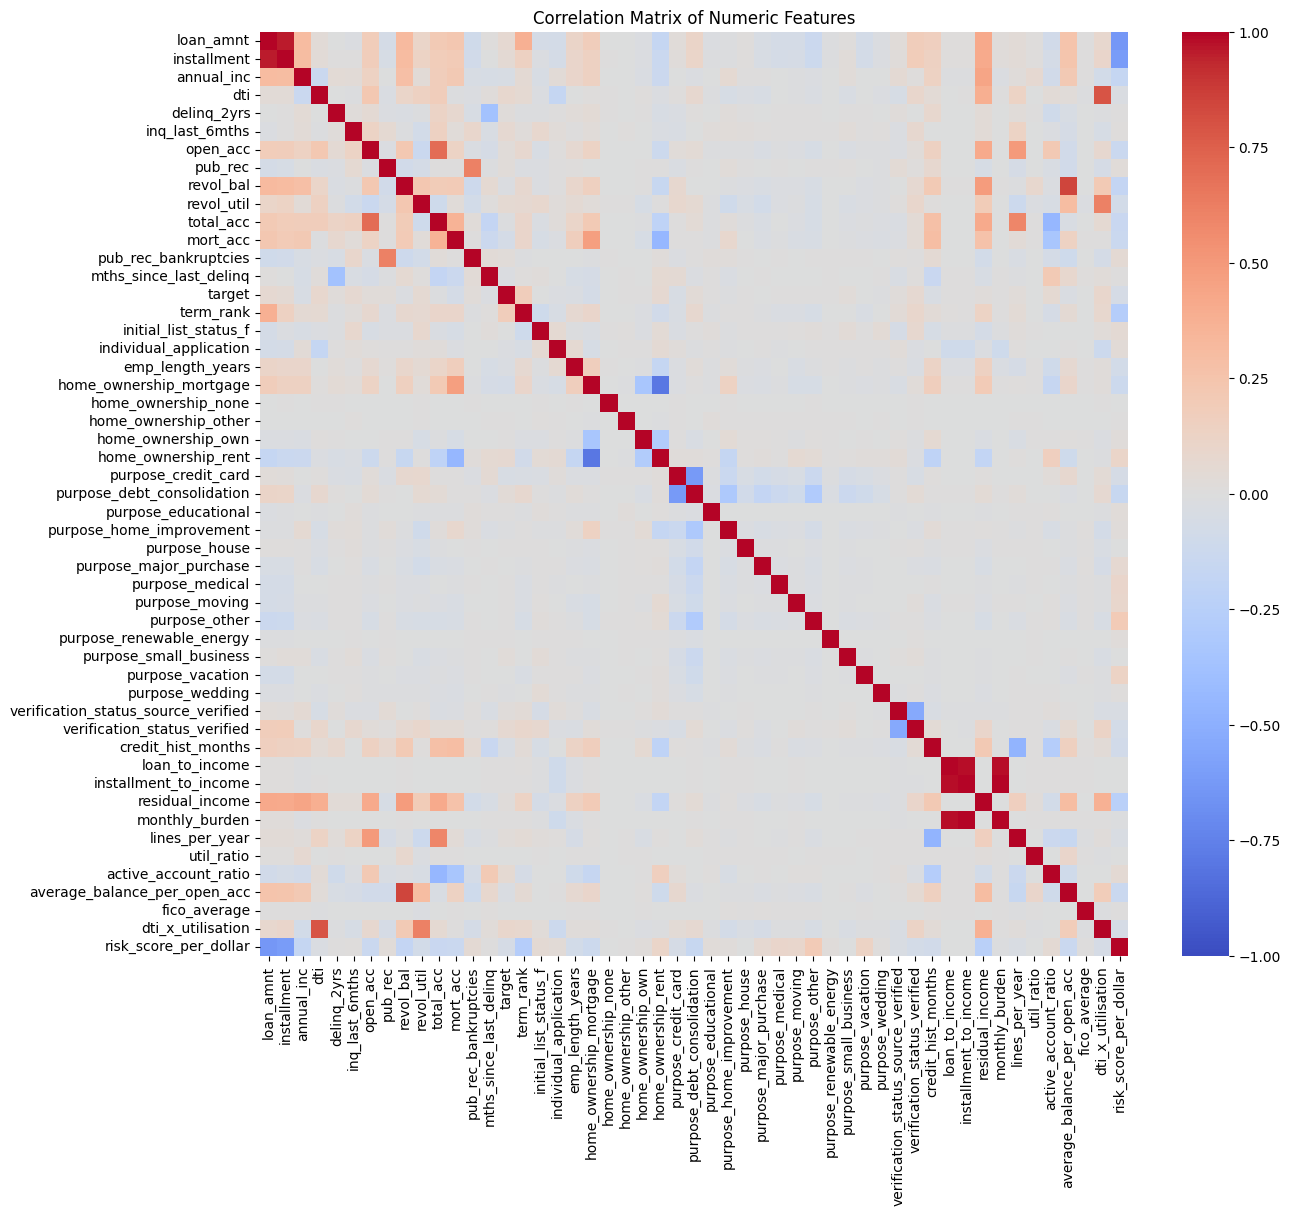

In [62]:
# Visualise linear correlation
final_cols = [col for col in df.columns if col not in ['issue_d', 'earliest_cr_line']]

numeric_df = df[final_cols].select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

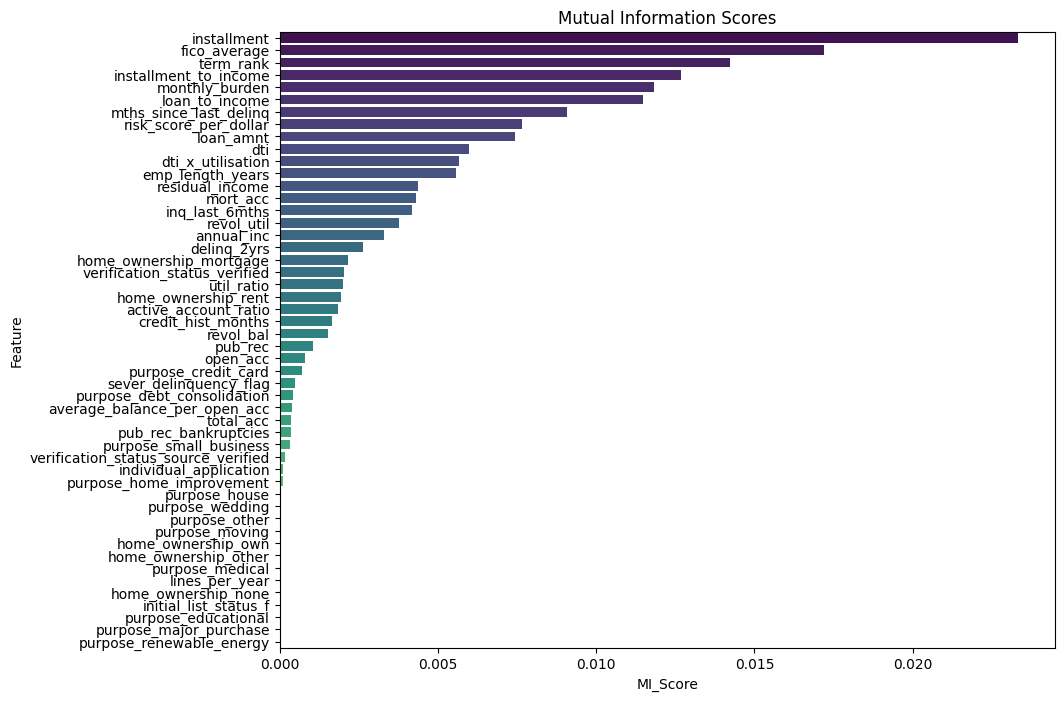

In [63]:
# Mutual information

# Sample and Split
sample_df = df[final_cols].sample(n=100000, random_state=0).copy()
X = sample_df.drop(columns=['target'], errors='ignore')
y = sample_df['target']

X = X.select_dtypes(exclude=['datetime64', 'datetime64[ns]'])

# Convert Boolean columns to integers (True/False -> 1/0)
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

# Factorize remaining 'object' columns
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.factorize(X[col])[0]

discrete_mask = X.dtypes != float

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=0)

# Plot
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False).head(50)

plt.figure(figsize=(10, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df, hue='Feature', palette='viridis', legend=False)
plt.title('Mutual Information Scores')
plt.show()


C:\Users\david_97mazrf\AppData\Local\Temp\ipykernel_25300\431199913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


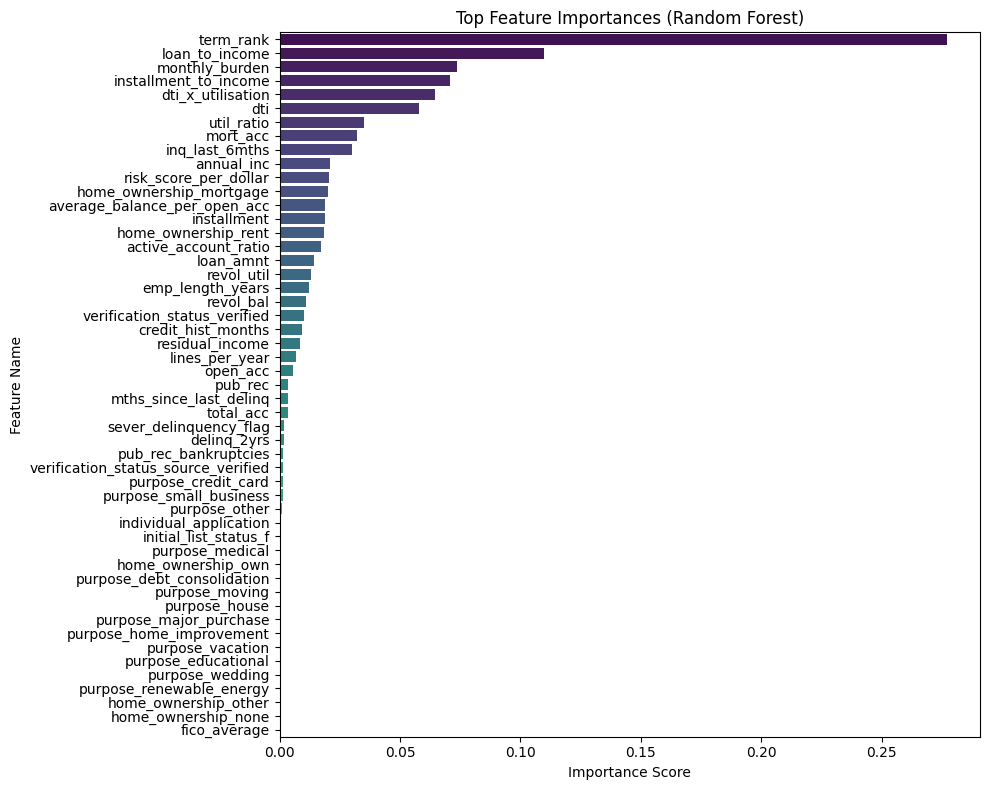

In [64]:
# Feture importance by means of Random Forest

rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
rf.fit(X, y) 

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")

plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

In [102]:
# Define cutoff for Out-of-Time (OOT) validation
oot_cutoff = pd.Timestamp('2014-01-01')

df_train = df[df['issue_d'] < oot_cutoff].copy()
df_oot = df[df['issue_d'] >= oot_cutoff].copy()

print("\n--- Split Summary ---")
print(f"Train/Test Volume: {len(df_train)}")
print(f"OOT Volume: {len(df_oot)}")
print(f"OOT Default Rate: {df_oot['target'].mean():.2%}")

df = df.drop(columns=['issue_d', 'earliest_cr_line'])
df_train = df_train.drop(columns=['issue_d', 'earliest_cr_line'])
df_oot = df_oot.drop(columns=['issue_d', 'earliest_cr_line'])


--- Split Summary ---
Train/Test Volume: 230706
OOT Volume: 1117393
OOT Default Rate: 20.88%


In [103]:
# Proportion of target values

print(f"Filtered Shape: {df.shape}")
print("\nTarget Distribution:")
print(df['target'].value_counts(normalize=True))

Filtered Shape: (1348099, 52)

Target Distribution:
target
0    0.800193
1    0.199807
Name: proportion, dtype: float64


In [104]:
# Save checkpoints
df_train.to_pickle('data_train.pkl')
df_oot.to_pickle('data_oot.pkl')

In [105]:
# Identify Categorical vs Numerical variables
target_col = 'target'

# Select features (excluding target and ignored cols)
features = [c for c in df_train.columns if c not in [target_col]]

num_cols = df_train[features].select_dtypes(include=['number']).columns.tolist()

In [106]:
binning_process = {}
iv_summary = []

df_train = df_train.replace([np.inf, -np.inf], np.nan)

for col in features:
    # Configuration
    dtype = "categorical" if col in categorical_columns else "numerical"
    
    # Enforce Monotonicity for numerical variables
    optb = OptimalBinning(
        name=col, 
        dtype=dtype, 
        solver="cp",
        monotonic_trend="auto_asc_desc" if dtype == "numerical" else "auto"
    )

    # Fit the Binner
    try:
        optb.fit(df_train[col], df_train[target_col])
    except Exception as e:
        print(f"Skipping {col} due to error: {e}")
        continue

    # Store Results
    binning_process[col] = optb
    
    # Get IV
    binning_table = optb.binning_table.build()
    iv = binning_table.loc['Totals', 'IV']
    iv_summary.append({'Variable': col, 'IV': iv})

In [137]:
df_iv = pd.DataFrame(iv_summary).sort_values('IV', ascending=False)

print("\n--- Top Predictive Variables (IV) ---")
print(df_iv.head(10))

selected_vars = df_iv[(df_iv['IV'] >= 0.02) & (df_iv['IV'] < 1.0)]['Variable'].tolist()
print(f"\nSelected {len(selected_vars)} variables for the Scorecard.")


--- Top Predictive Variables (IV) ---
                 Variable        IV
14              term_rank  0.147235
39         loan_to_income  0.109317
40  installment_to_income  0.082781
42         monthly_burden  0.082757
49      dti_x_utilisation  0.063989
3                     dti  0.042318
9              revol_util  0.040654
2              annual_inc  0.039590
5          inq_last_6mths  0.034599
50  risk_score_per_dollar  0.025894

Selected 12 variables for the Scorecard.


In [ ]:
# Transform both Train and OOT datasets using the bins learned from train

X_train_woe = pd.DataFrame(index=df_train.index)
X_oot_woe = pd.DataFrame(index=df_oot.index)

for col in selected_vars:
    optb = binning_process[col]
    X_train_woe[col] = optb.transform(df_train[col], metric="woe")
    X_oot_woe[col] = optb.transform(df_oot[col], metric="woe")

# Add target back for modelling convenience
X_train_woe['target'] = df_train[target_col].values
X_oot_woe['target'] = df_oot[target_col].values

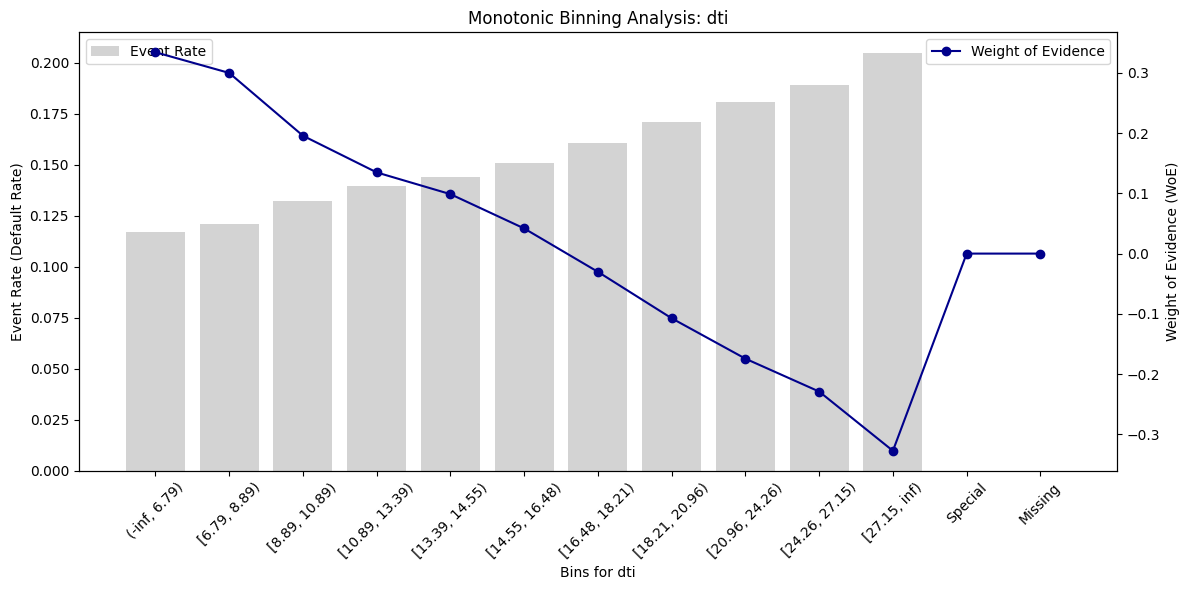

In [138]:
# Plot the binning table for a specified variable

variable = 'dti'
optb = binning_process[variable]
table = optb.binning_table.build()

# Remove the 'Totals' row
plot_table = table.iloc[:-1, :].copy()

# Ensure 'Bin' is treated as string for categorical plotting
bin_labels = plot_table['Bin'].astype(str).tolist()
x_pos = np.arange(len(bin_labels))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Use x_pos for bar placement
ax1.bar(x_pos, plot_table['Event rate'], color='lightgrey', label='Event Rate')
ax1.set_ylabel('Event Rate (Default Rate)')
ax1.set_xlabel(f'Bins for {variable}')

# Align xticks with labels
ax1.set_xticks(x_pos)
ax1.set_xticklabels(bin_labels, rotation=45)

# Line chart for WoE
ax2 = ax1.twinx()
ax2.plot(x_pos, plot_table['WoE'], marker='o', color='darkblue', label='Weight of Evidence')
ax2.set_ylabel('Weight of Evidence (WoE)')

plt.title(f'Monotonic Binning Analysis: {variable}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [109]:
# Fitting Logistic model

y_train = X_train_woe['target']
X_train_final = X_train_woe.drop(columns=['target'])

def backward_elimination(X, y, significance_level=0.05):
    """
    Repeatedly fits a Logit model and removes the least significant variable
    until all variables have a p-value < significance_level.
    """
    if 'const' not in X.columns:
        X = sm.add_constant(X)
    
    features = list(X.columns)
    
    while True:
        model = sm.Logit(y, X[features]).fit(disp=0)
        
        p_values = model.pvalues
        
        max_p_value = p_values.max()
        max_p_feature = p_values.idxmax()
        
        if max_p_value > significance_level:
            print(f"Dropping '{max_p_feature}' with p-value: {max_p_value:.4f}")
            features.remove(max_p_feature)
            
            if max_p_feature == 'const':
                 print("WARNING: Intercept was statistically insignificant. Consider scaling data or keeping it anyway.")
        else:
            print("\nAll remaining variables are significant!")
            break
            
    final_model = sm.Logit(y, X[features]).fit()
    return final_model, features

result, kept_features = backward_elimination(X_train_final, y_train)

print(result.summary())

Dropping 'monthly_burden' with p-value: 0.7385
Dropping 'dti_x_utilisation' with p-value: 0.2579
Dropping 'loan_amnt' with p-value: 0.2188

All remaining variables are significant!
Optimization terminated successfully.
         Current function value: 0.411271
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               230706
Model:                          Logit   Df Residuals:                   230696
Method:                           MLE   Df Model:                            9
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                 0.05188
Time:                        10:44:44   Log-Likelihood:                -94883.
converged:                       True   LL-Null:                   -1.0007e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.

In [110]:
# Scorecard scaling parameters

target_score = 600
target_odds = 50
points_duble_odds = 20

# Calculate Factor and Offset
factor = points_duble_odds / np.log(2)
offset = target_score - (factor * np.log(target_odds))

print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

Factor: 28.8539
Offset: 487.1229


In [111]:
# Generate scores for OOT validation data

if 'const' not in X_oot_woe.columns:
    X_oot_woe = sm.add_constant(X_oot_woe)

X_oot_final = X_oot_woe[kept_features]

logits_oot = result.predict(X_oot_final, transform=False)
log_odds = np.log(logits_oot / (1 - logits_oot))

# We want Score to drop as Risk increases
scores_oot = offset - (factor * log_odds)

# Cap scores to standard range
scores_oot = scores_oot.round().astype(int)

# Attach scores to the OOT dataframe for analysis
df_oot_scored = df_oot.copy()
df_oot_scored['score'] = scores_oot
df_oot_scored['pd_prob'] = result.predict(X_oot_final)

# Remove NA values
df_oot_scored = df_oot_scored.dropna(subset=['pd_prob'])

print("\n--- OOT Score Distribution ---")
print(df_oot_scored['score'].describe())


--- OOT Score Distribution ---
count    1.117393e+06
mean     5.422036e+02
std      1.722148e+01
min      4.780000e+02
25%      5.310000e+02
50%      5.430000e+02
75%      5.540000e+02
max      5.940000e+02
Name: score, dtype: float64


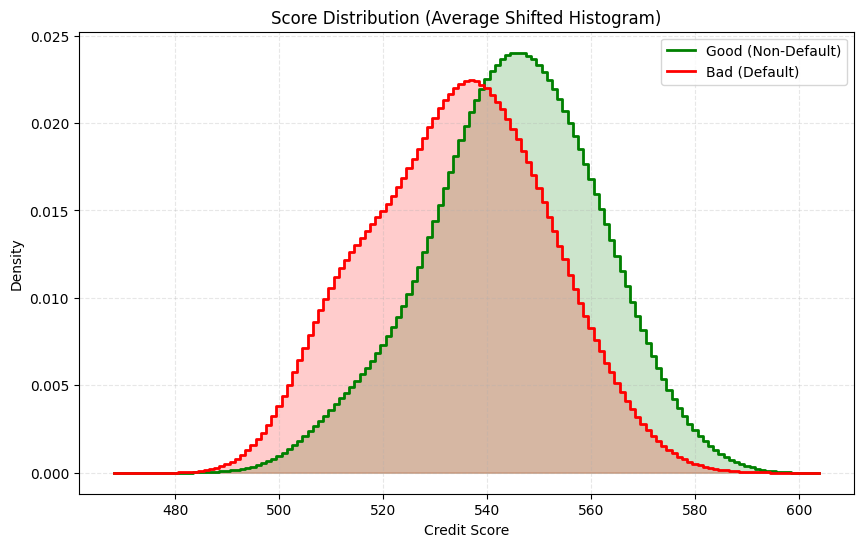

In [112]:

def plot_ash(data, bin_width, m=10, color='blue', label='ASH'):
    """
    Plots an Average Shifted Histogram (ASH).
    
    Parameters:
    - data: Array of values (scores)
    - bin_width: The width of the base histogram bins (h)
    - m: Number of shifts (higher = smoother)
    """
    # Define the small sub-bin width (delta)
    delta = bin_width / m
    
    # Compute counts in these tiny bins
    min_val = np.min(data) - bin_width
    max_val = np.max(data) + bin_width
    n_bins = int(np.ceil((max_val - min_val) / delta))
    
    counts, edges = np.histogram(data, bins=n_bins, range=(min_val, max_val))
    

    window = np.ones(m) / m 
    ash_counts = np.convolve(counts, window, mode='same')

    ash_density = ash_counts / (len(data) * delta) 
    
    centers = (edges[:-1] + edges[1:]) / 2
    plt.step(centers, ash_density, where='mid', label=label, color=color, linewidth=2)
    plt.fill_between(centers, ash_density, step='mid', alpha=0.2, color=color)

plt.figure(figsize=(10, 6))

bin_width = 10
m = 20

# Good Loans (Green)
plot_ash(df_oot_scored[df_oot_scored['target']==0]['score'], 
         bin_width=bin_width, m=m, color='green', label='Good (Non-Default)')

# Bad Loans (Red)
plot_ash(df_oot_scored[df_oot_scored['target']==1]['score'], 
         bin_width=bin_width, m=m, color='red', label='Bad (Default)')

plt.title('Score Distribution (Average Shifted Histogram)')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [113]:
def calculate_ks_metric(df, target_col='target', prob_col='pd_prob'):
    """
    Calculates the Kolmogorov-Smirnov (KS) statistic using Scipy

    Measures the maximum separation between the cumulative distribution 
    functions of Goods (Non-Events) and Bads (Events)

    Args:
        df (pd.DataFrame): The dataframe containing target labels and predicted probabilities
        target_col (str, optional): Name of the binary target column. Defaults to 'target'
        prob_col (str, optional): Name of the predicted probability column. Defaults to 'pd_prob'

    Returns:
        float: The KS statistic (D), representing the maximum distance between the two distributions
    """


    # Separate the probabilities for Goods and Bads
    probs_bad = df[df[target_col] == 1][prob_col]
    probs_good = df[df[target_col] == 0][prob_col]
    
    # Calculate KS
    ks_stat, p_value = ks_2samp(probs_bad, probs_good)
    
    return ks_stat

ks_value = calculate_ks_metric(df_oot_scored)
print(ks_value)

0.24632810609365696


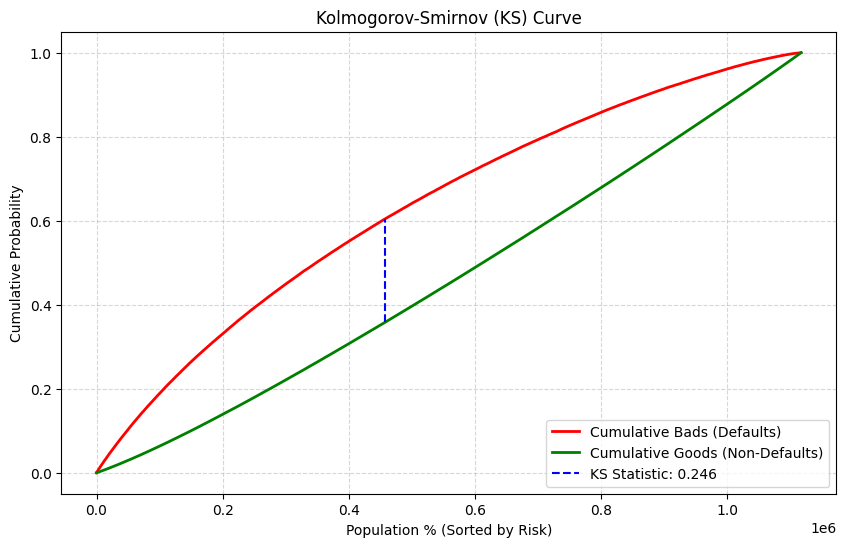

In [114]:
# Generate KS plot

# Sort by predicted probability
df_sorted = df_oot_scored.sort_values(by='pd_prob', ascending=False).reset_index(drop=True)

# Calculate Cumulative Counts
df_sorted['cum_bad'] = df_sorted['target'].cumsum()
df_sorted['cum_good'] = (1 - df_sorted['target']).cumsum()

df_sorted['cum_bad_pct'] = df_sorted['cum_bad'] / df_sorted['target'].sum()
df_sorted['cum_good_pct'] = df_sorted['cum_good'] / (1 - df_sorted['target']).sum()

df_sorted['ks_diff'] = abs(df_sorted['cum_bad_pct'] - df_sorted['cum_good_pct'])

max_ks_row = df_sorted.loc[df_sorted['ks_diff'].idxmax()]


# Plotting
plt.figure(figsize=(10, 6))

# Plot CDF
plt.plot(df_sorted['cum_bad_pct'], label='Cumulative Bads (Defaults)', color='red', linewidth=2)
plt.plot(df_sorted['cum_good_pct'], label='Cumulative Goods (Non-Defaults)', color='green', linewidth=2)

# Plot the KS Vertical Line
plt.vlines(x=max_ks_row.name, ymin=max_ks_row['cum_good_pct'], ymax=max_ks_row['cum_bad_pct'], 
           colors='blue', linestyles='dashed', label=f'KS Statistic: {ks_value:.3f}')

plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.xlabel('Population % (Sorted by Risk)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [115]:
# Use df_oot_scored, where you saved the probabilities earlier
auc = roc_auc_score(df_oot_scored['target'], df_oot_scored['pd_prob'])
gini = 2 * auc - 1

print(f"AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")

AUC: 0.6707
Gini: 0.3415


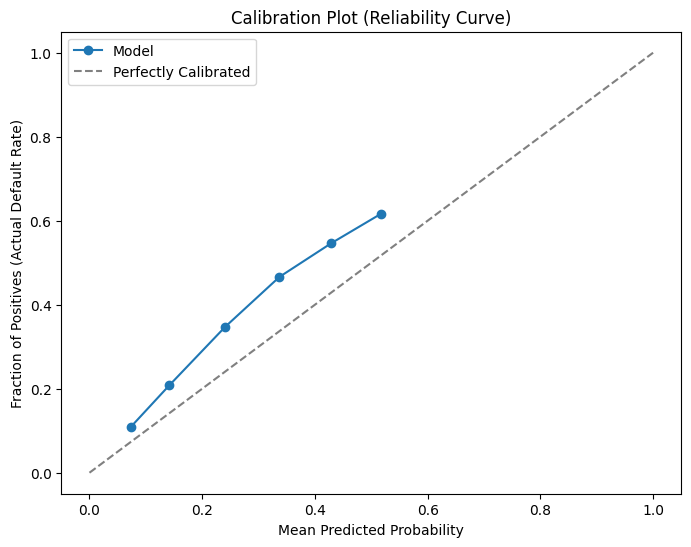

In [116]:
prob_true, prob_pred = calibration_curve(df_oot_scored['target'], df_oot_scored['pd_prob'], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Default Rate)')
plt.title('Calibration Plot (Reliability Curve)')
plt.legend()
plt.show()

In [117]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables'''
    
    def psi(expected_array, actual_array, buckets):
        # Define Breakpoints
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            # Use unique breakpoints to avoid "monotonically increasing" errors
            breakpoints = np.unique(np.percentile(expected_array, breakpoints))
        
        # Calculate Frequencies
        # We clip actuals to ensure they fall within the expected range        
        min_val = expected_array.min()
        max_val = expected_array.max()
        actual_array_clipped = np.clip(actual_array, min_val, max_val)
        
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array_clipped, breakpoints)[0] / len(actual_array)

        # Vectorized PSI Calculation (Fixes the DeprecationWarning)
        expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
        actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
        
        # Calculate for entire array at once (No loop!)
        psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
        
        return np.sum(psi_values)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    if len(expected.shape) == 1:
        psi_values = psi(expected, actual, buckets)
    elif axis == 0:
        for i in range(0, expected.shape[1]):
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
    elif axis == 1:
        for i in range(0, expected.shape[0]):
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return psi_values


if 'const' not in X_train_woe.columns:
    X_train_woe = sm.add_constant(X_train_woe)

X_train_final = X_train_woe[kept_features]

logits_train = result.predict(X_train_final, transform=False)
log_odds = np.log(logits_train / (1 - logits_train))

train_scores = offset - (factor * log_odds)

expected_scores = train_scores
actual_scores = df_oot_scored['score']

actual_scores = actual_scores

psi_score = calculate_psi(expected_scores, actual_scores, buckets=10)
print(f"System Stability Index (PSI): {psi_score:.4f}")

System Stability Index (PSI): 0.0391


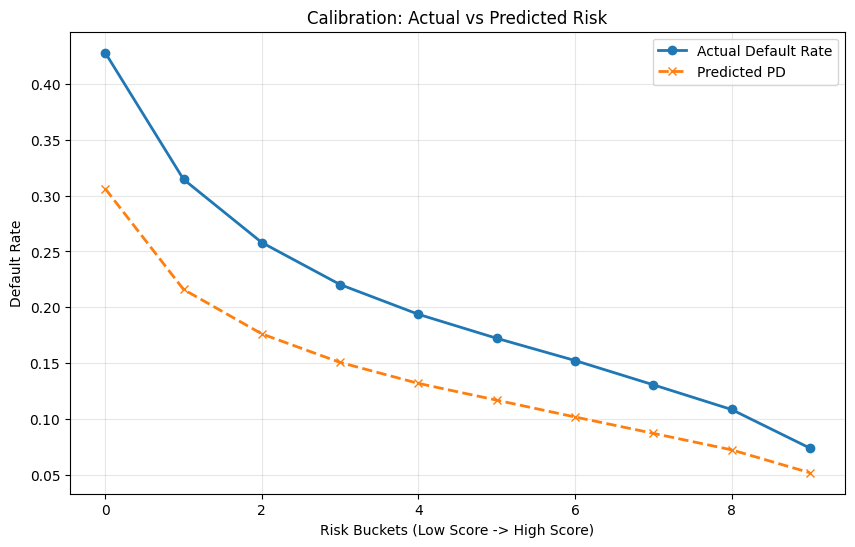

                  Actual_DR  Predicted_PD  Volume
bucket                                           
(477.999, 519.0]   0.427855      0.306172  119225
(519.0, 528.0]     0.314519      0.215989  114381
(528.0, 534.0]     0.257953      0.176196  116246
(534.0, 539.0]     0.220359      0.150668  120567
(539.0, 543.0]     0.193736      0.131900  103450
(543.0, 547.0]     0.172271      0.116900  104231
(547.0, 552.0]     0.152386      0.101862  122098
(552.0, 557.0]     0.130662      0.087196  104108
(557.0, 564.0]     0.108542      0.072432  108364
(564.0, 594.0]     0.074024      0.051950  104723


In [118]:
# Create risk buckets (deciles)
df_oot_scored['bucket'] = pd.qcut(df_oot_scored['score'], q=10, duplicates='drop')

# Calculate Average PD vs Actual Default Rate per bucket
calibration = df_oot_scored.groupby('bucket', observed=False).agg({
    'target': 'mean',
    'pd_prob': 'mean',
    'score': 'count'
})

# Rename for clarity
calibration.columns = ['Actual_DR', 'Predicted_PD', 'Volume']

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(calibration)), calibration['Actual_DR'], marker='o', label='Actual Default Rate', linewidth=2)
plt.plot(range(len(calibration)), calibration['Predicted_PD'], marker='x', linestyle='--', label='Predicted PD', linewidth=2)
plt.title("Calibration: Actual vs Predicted Risk")
plt.xlabel("Risk Buckets (Low Score -> High Score)")
plt.ylabel("Default Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(calibration)